In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PoductDemand.csv")

In [3]:
print(data.head())

   ID  Store ID  Total Price  Base Price  Units Sold
0   1      8091      99.0375    111.8625          20
1   2      8091      99.0375     99.0375          28
2   3      8091     133.9500    133.9500          19
3   4      8091     133.9500    133.9500          44
4   5      8091     141.0750    141.0750          52


In [4]:

data.fillna(data.mean(), inplace=True)

In [5]:
data.isna().sum()

ID             0
Store ID       0
Total Price    0
Base Price     0
Units Sold     0
dtype: int64

In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta

start_date = pd.to_datetime("1984-01-01")
end_date = pd.to_datetime("2020-12-31")
date_range = [start_date + timedelta(days=np.random.randint(0, (end_date - start_date).days + 1)) for _ in range(len(data))]


data['date'] = date_range

data.to_csv('output_data.csv', index=False)


In [7]:
df = pd.read_csv("/content/output_data.csv",parse_dates=['date'])

In [8]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d") #If need extract year, month and day to new columns:



In [9]:
# per 1 store, 1 item
train_df = df[df['Store ID']==1]
train_df = df[df['Base Price']==1]
train_df = df[df['Base Price']==1]

train_df = data.set_index('ID')
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday
train_df.head()

,Store ID,Total Price,Base Price,Units Sold,date,year,month,day,weekday
ID,,,,,,,,,
1,8091,99.0375,111.8625,20,2018-07-28,2018,7,209,5
2,8091,99.0375,99.0375,28,1997-03-28,1997,3,87,4
3,8091,133.9500,133.9500,19,2000-02-15,2000,2,46,1
4,8091,133.9500,133.9500,44,1989-07-08,1989,7,189,5
5,8091,141.0750,141.0750,52,2002-06-21,2002,6,172,4


<Axes: xlabel='date', ylabel='Units Sold'>

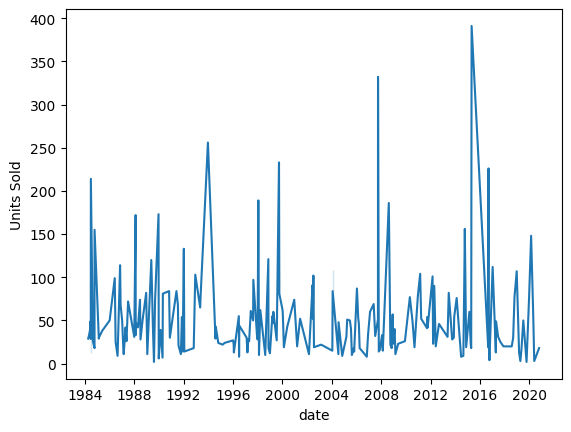

In [10]:
sns.lineplot(x=train_df["date"].head(200), y=train_df["Units Sold"].head(200),legend = 'full' )

<Axes: xlabel='weekday', ylabel='Units Sold'>

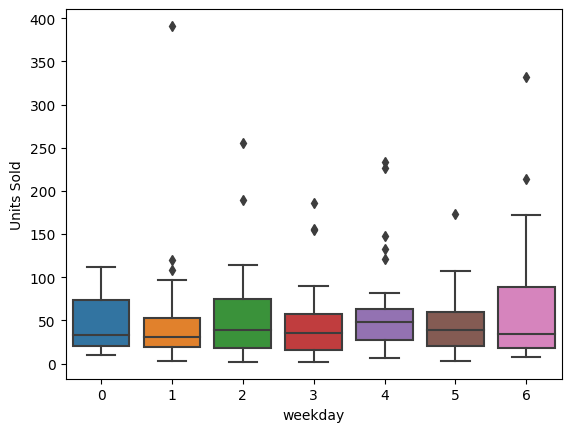

In [11]:
sns.boxplot(x=train_df["weekday"].head(200), y=train_df["Units Sold"].head(200), data=train_df)

In [12]:
train_df = df.set_index('date')
train_df['Units Sold'] = train_df['Units Sold'].astype(float)
train_df.head()

,ID,Store ID,Total Price,Base Price,Units Sold
date,,,,,
2018-07-28,1,8091,99.0375,111.8625,20.0
1997-03-28,2,8091,99.0375,99.0375,28.0
2000-02-15,3,8091,133.9500,133.9500,19.0
1989-07-08,4,8091,133.9500,133.9500,44.0
2002-06-21,5,8091,141.0750,141.0750,52.0


In [13]:
train_df.shape

(150150, 5)

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example usage with a period of 12 for monthly data (adjust to your data's seasonality)
result = seasonal_decompose(df['Units Sold'].head(1000), model='additive', period=12)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid


<Figure size 640x480 with 0 Axes>

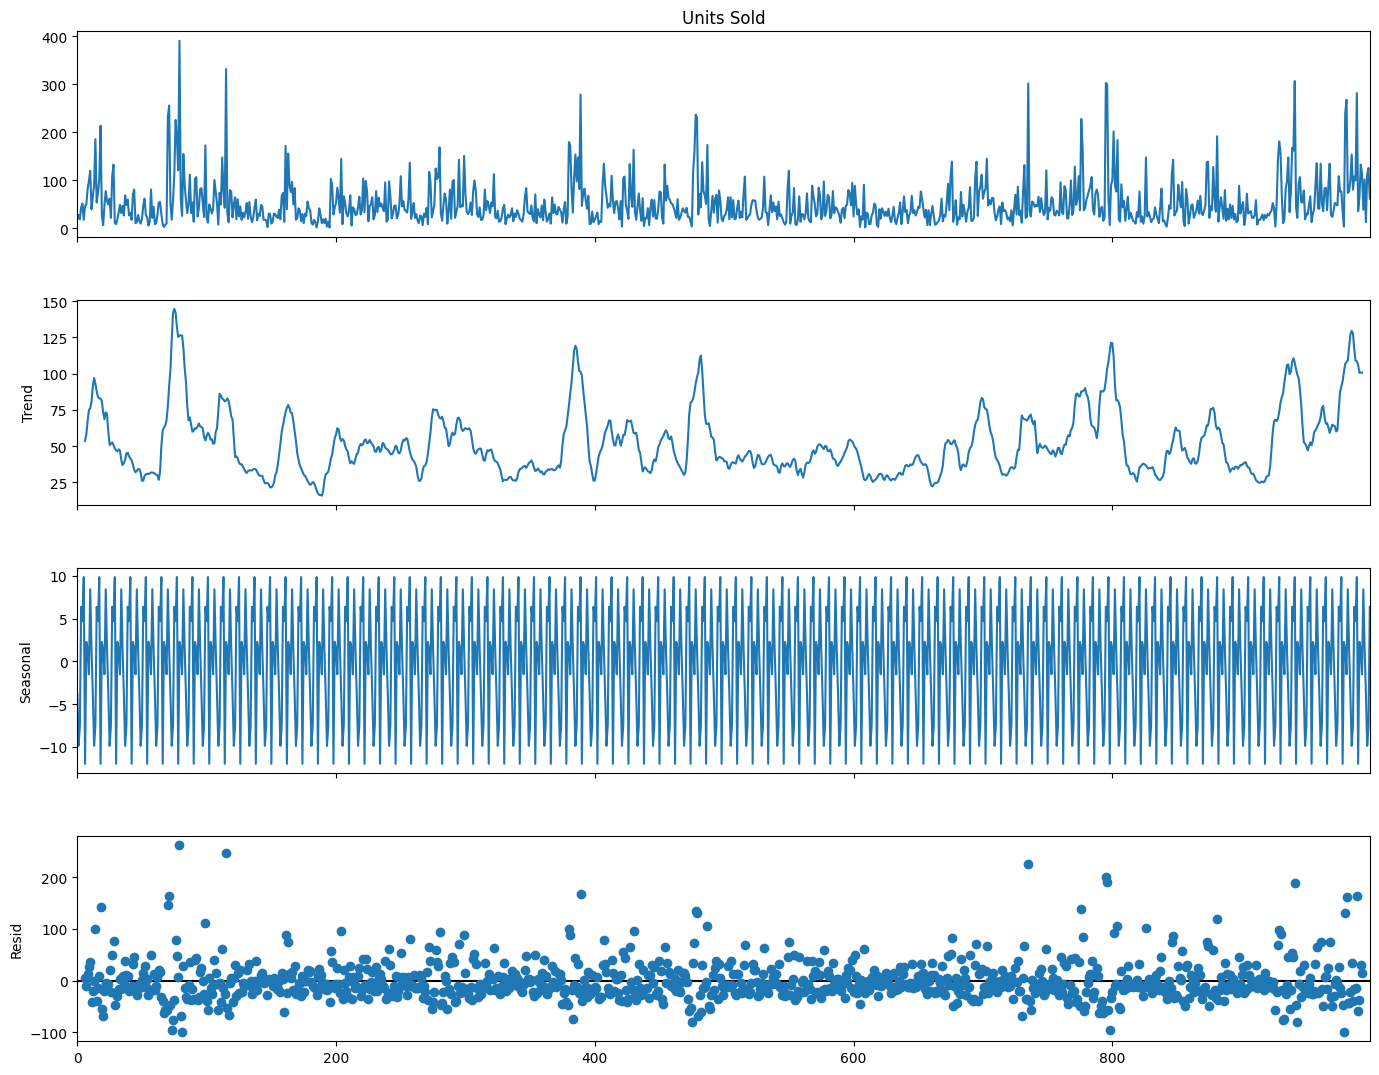

In [15]:
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15, 12)

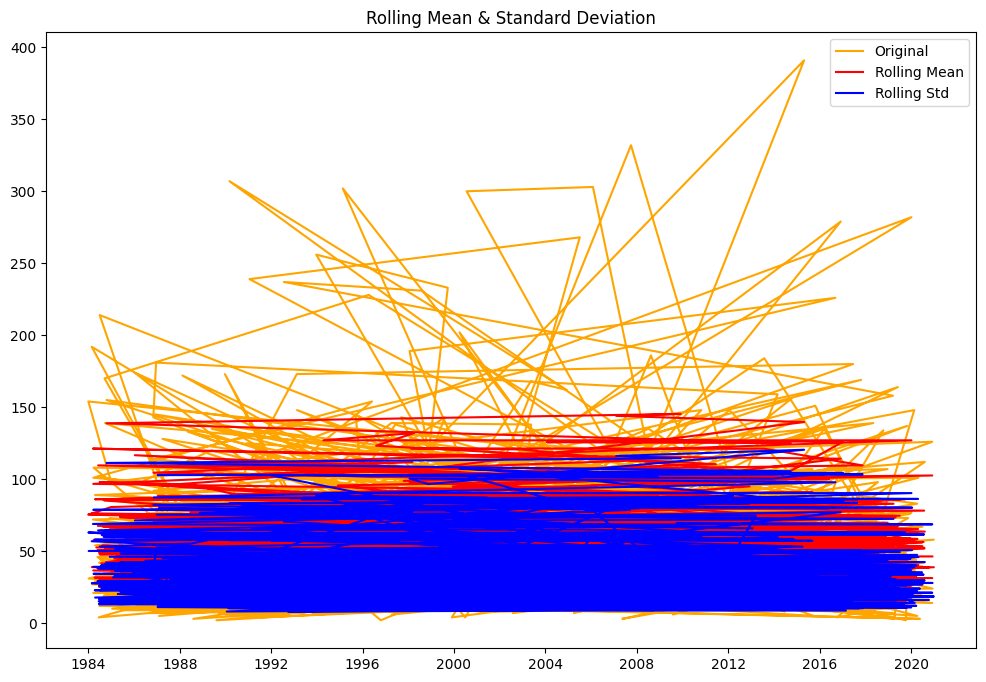

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -5.325437
p-value                          0.000005
#Lags Used                      20.000000
Number of Observations Used    979.000000
Critical Value (1%)             -3.437047
Critical Value (5%)             -2.864497
Critical Value (10%)            -2.568344
dtype: float64


In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

  #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig= plt.figure(figsize=(12,8))
    orig = plt.plot(timeseries, color='orange',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


      #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)




test_stationarity(train_df['Units Sold'].head(1000))

In [52]:
sales = train_df["Units Sold"].head(1000)

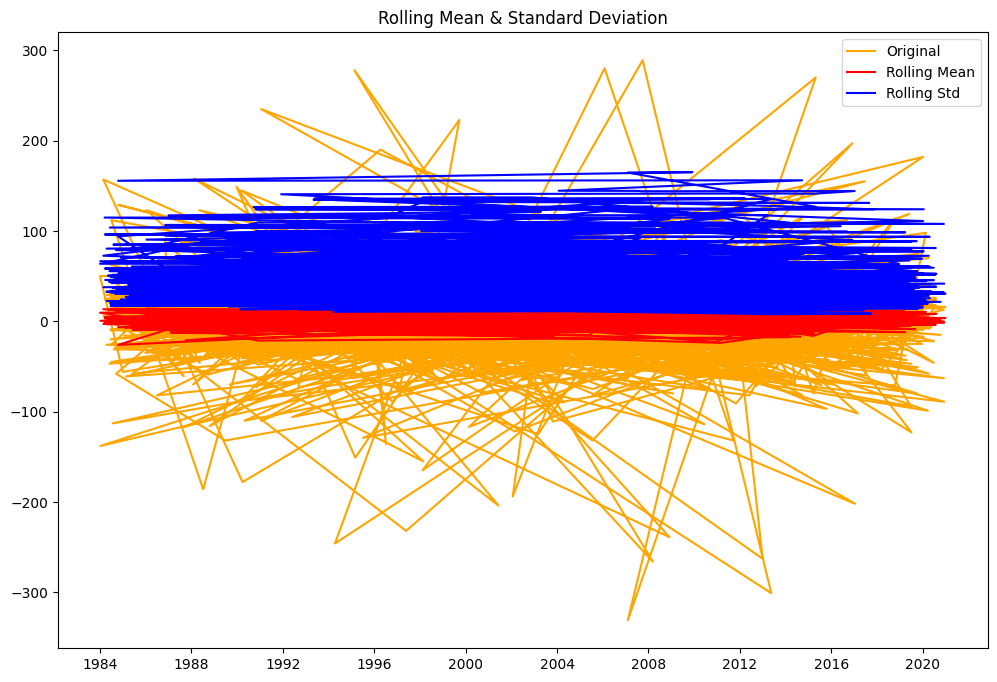

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.129548e+01
p-value                        1.347063e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


In [53]:
first_diff = sales - sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

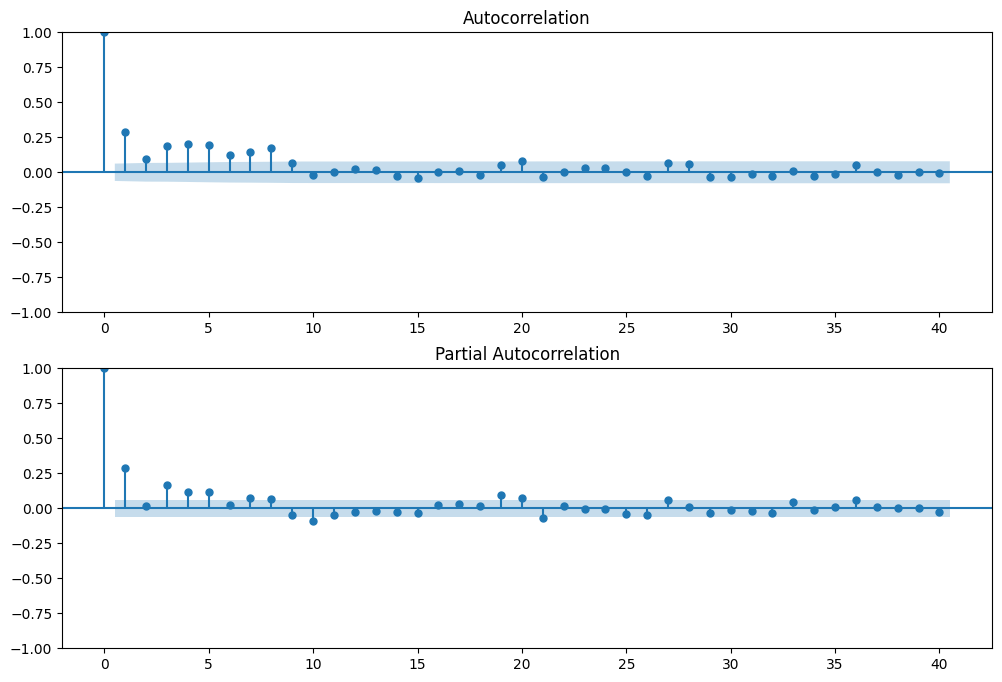

In [19]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sales, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sales, lags=40, ax=ax2)

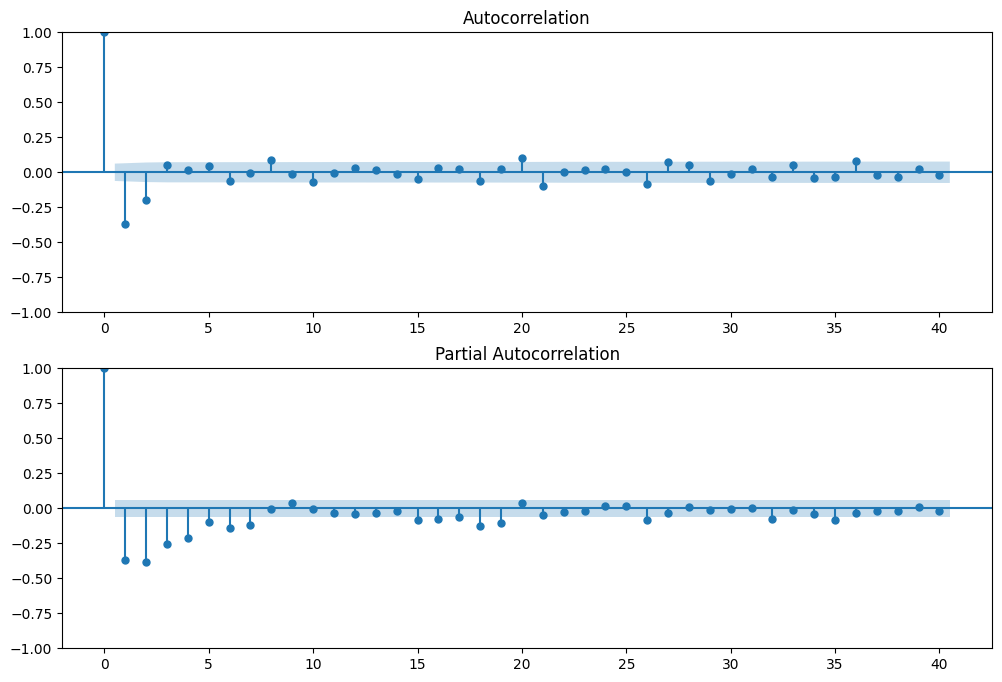

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

In [21]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sales, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                 1000
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5214.255
Date:                Thu, 26 Oct 2023   AIC                          10440.509
Time:                        06:54:48   BIC                          10469.950
Sample:                             0   HQIC                         10451.699
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6797      0.016    -41.709      0.000      -0.712      -0.648
ar.L2         -0.6586      0.028    -23.422      0.000      -0.714      -0.603
ar.L3         -0.4430      0.029    -15.362      0.0

NormaltestResult(statistic=375.55666808698606, pvalue=2.811290363450702e-82)


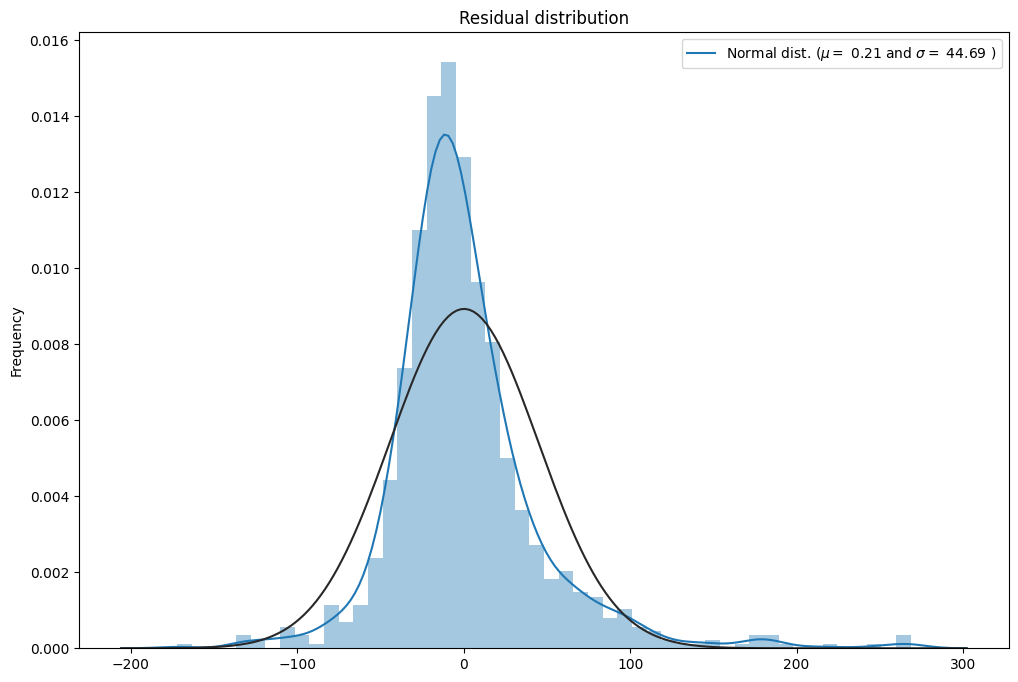

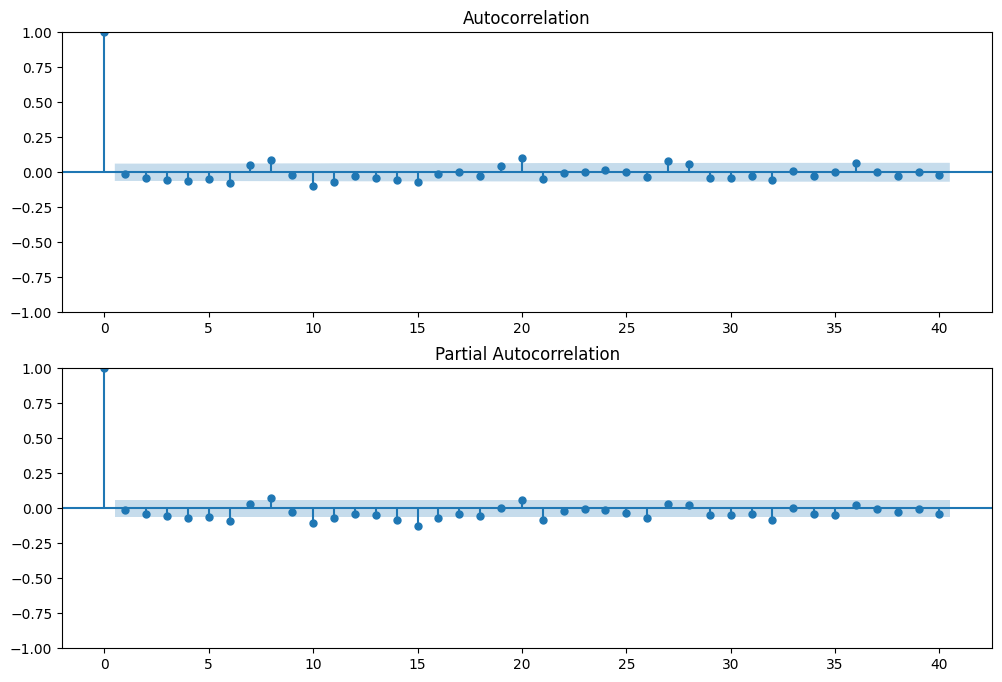

In [22]:
from scipy import stats
from scipy.stats import normaltest

resid = model_fit.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_fit.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_fit.resid, lags=40, ax=ax2)


In [23]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Units Sold   No. Observations:                 1000
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5204.423
Date:                Thu, 26 Oct 2023   AIC                          10422.846
Time:                        06:54:50   BIC                          10457.193
Sample:                             0   HQIC                         10435.901
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6938      0.017    -41.599      0.000      -0.726      -0.661
ar.L2         -0.6970      0.029    -23.998      0.000      -0.754      -0.640
ar.L3         -0.5048      0.030    -17.054      0.0

NormaltestResult(statistic=407.3417461508226, pvalue=3.52260298625972e-89)


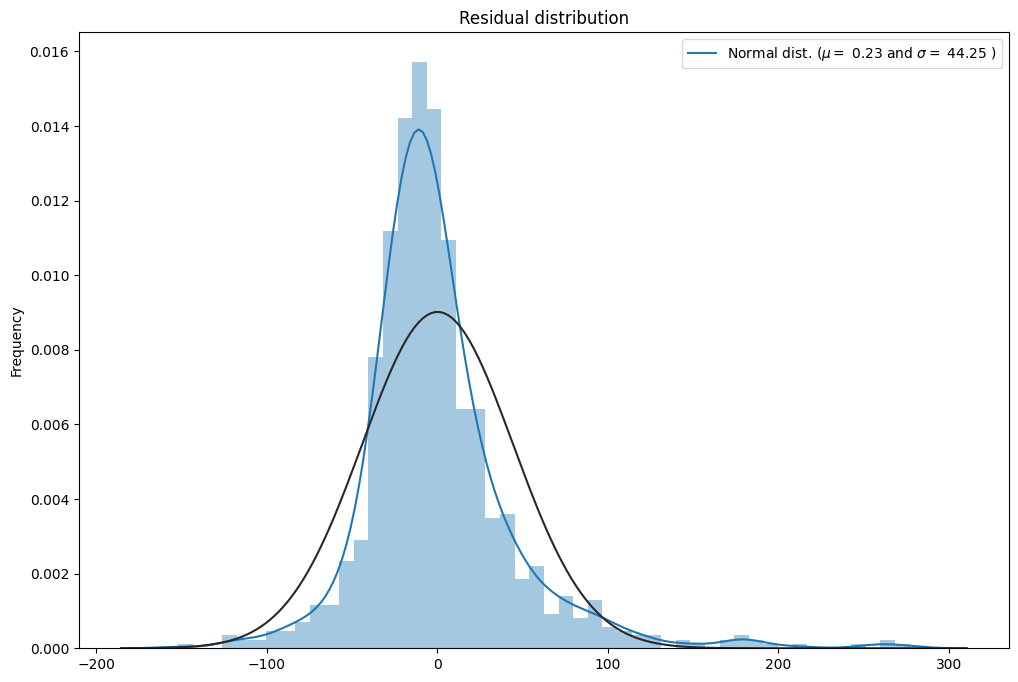

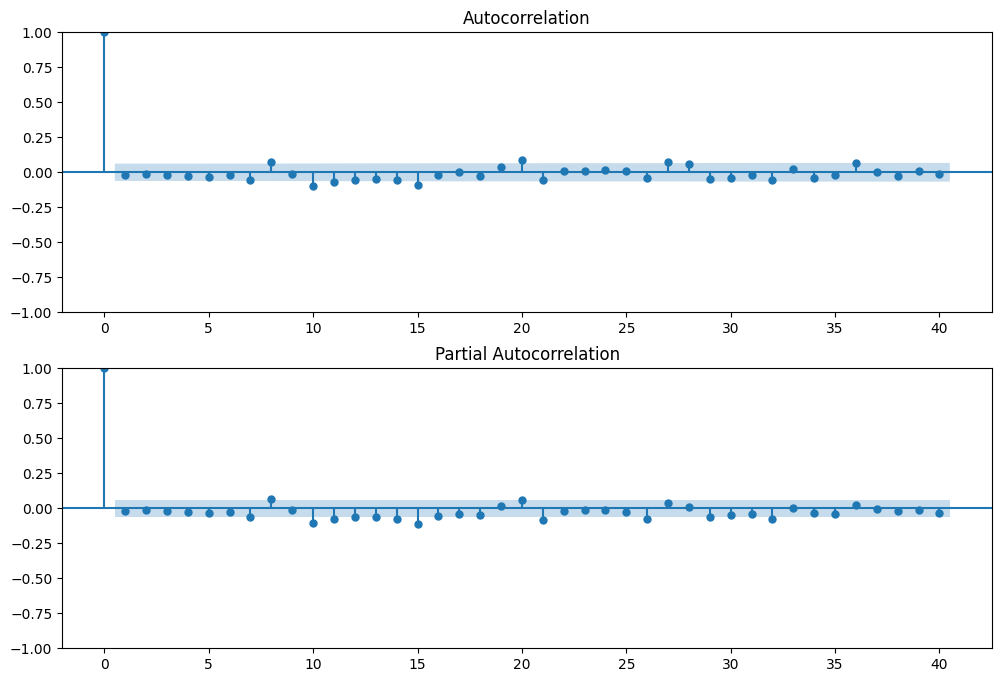

In [24]:
resid = sarima_mod6.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod6.resid, lags=40, ax=ax2)

<Axes: xlabel='date'>

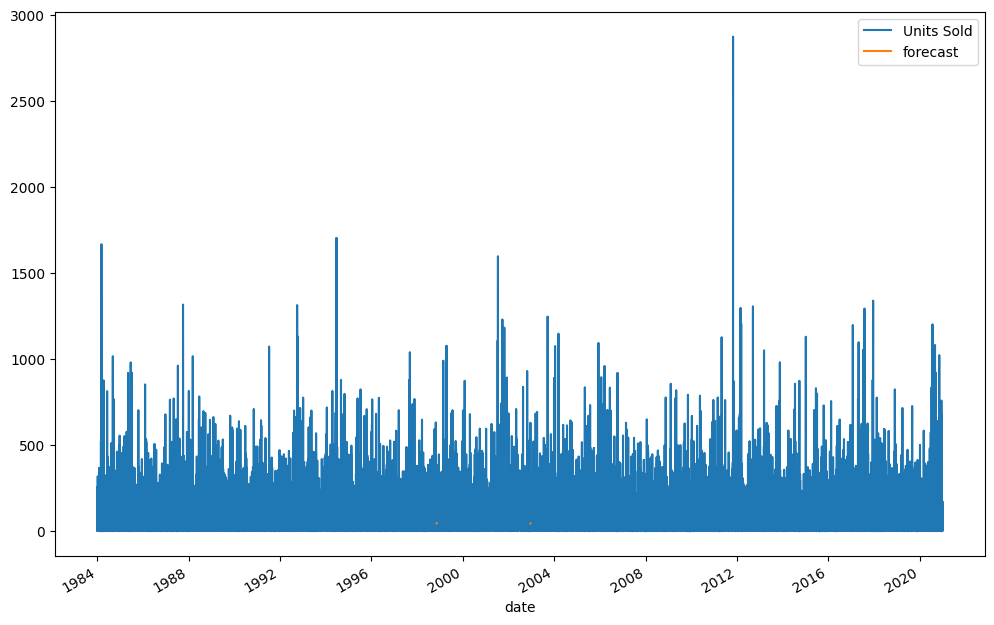

In [25]:
start_index = 730
end_index = 826
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)
train_df[["Units Sold", 'forecast']].plot(figsize=(12, 8))

In [26]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

smape_kun(train_df[1730:1825]['Units Sold'],train_df[1730:1825]['forecast'])

MAPE: 68.92 % 
SMAPE: 1.19 %


In [27]:
sales = df["Units Sold"].head(1000)

predicted=20.241957, expected=30.000000
predicted=26.259870, expected=47.000000
predicted=29.014459, expected=26.000000
predicted=25.821431, expected=8.000000
predicted=23.344031, expected=9.000000
predicted=22.485048, expected=13.000000
predicted=20.374427, expected=17.000000
predicted=16.683850, expected=28.000000
predicted=17.269770, expected=62.000000
predicted=29.199865, expected=15.000000
predicted=21.457612, expected=28.000000
predicted=31.061115, expected=25.000000
predicted=29.989091, expected=54.000000
predicted=38.511915, expected=93.000000
predicted=49.768361, expected=38.000000
predicted=40.656699, expected=109.000000
predicted=71.100739, expected=139.000000
predicted=87.257141, expected=14.000000
predicted=63.843909, expected=31.000000
predicted=71.207072, expected=59.000000
predicted=68.176048, expected=8.000000
predicted=44.971416, expected=23.000000
predicted=36.879088, expected=19.000000
predicted=25.652899, expected=76.000000
predicted=42.302160, expected=25.000000
p

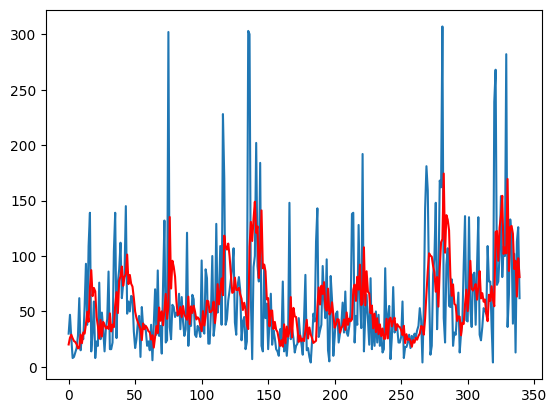

In [28]:
from math import sqrt
from sklearn.metrics import mean_squared_error
X = sales.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [29]:
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
df.head()

,ID,Store ID,Total Price,Base Price,Units Sold,date
0,1,8091,99.0375,111.8625,20,2018-07-28
1,2,8091,99.0375,99.0375,28,1997-03-28
2,3,8091,133.9500,133.9500,19,2000-02-15
3,4,8091,133.9500,133.9500,44,1989-07-08
4,5,8091,141.0750,141.0750,52,2002-06-21


In [31]:
df.drop(df[['Base Price']],axis = 1, inplace = True)
df.drop(df[['Total Price', 'Store ID', 'ID']],axis = 1, inplace = True)

In [32]:
df = df.rename(columns={'date': 'ds',
                        'Units Sold': 'y'})

df.head()

,y,ds
0,20,2018-07-28
1,28,1997-03-28
2,19,2000-02-15
3,44,1989-07-08
4,52,2002-06-21


Text(0.5, 0, 'Date')

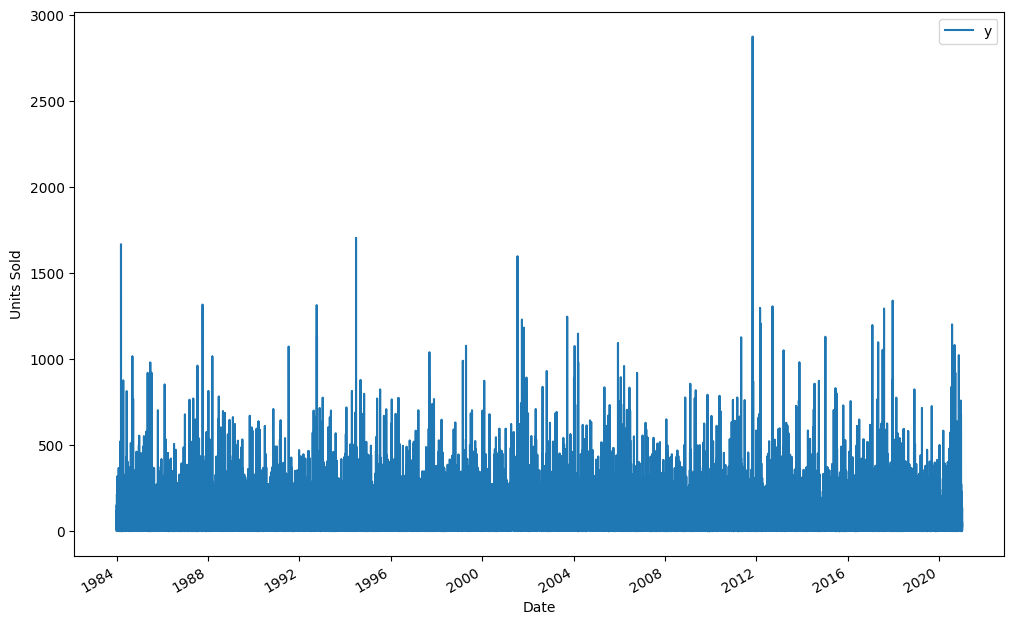

In [33]:
ax = df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Units Sold')
ax.set_xlabel('Date')

In [34]:
my_model = Prophet(interval_width=0.95)

In [35]:
my_model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/rtdp6hyb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/6y2e_8ux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86772', 'data', 'file=/tmp/tmptqvufj43/rtdp6hyb.json', 'init=/tmp/tmptqvufj43/6y2e_8ux.json', 'output', 'file=/tmp/tmptqvufj43/prophet_modelq977524_/prophet_model-20231026065738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:57:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [36]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.head()

,ds
0,1984-01-01
1,1984-01-02
2,1984-01-03
3,1984-01-04
4,1984-01-05


In [37]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,1984-01-01,51.759510,-56.541314,164.885119
1,1984-01-02,50.826224,-67.483303,169.090470
2,1984-01-03,50.555434,-69.779824,162.652600
3,1984-01-04,51.542677,-70.258857,159.743235
4,1984-01-05,51.891495,-60.984698,176.068224


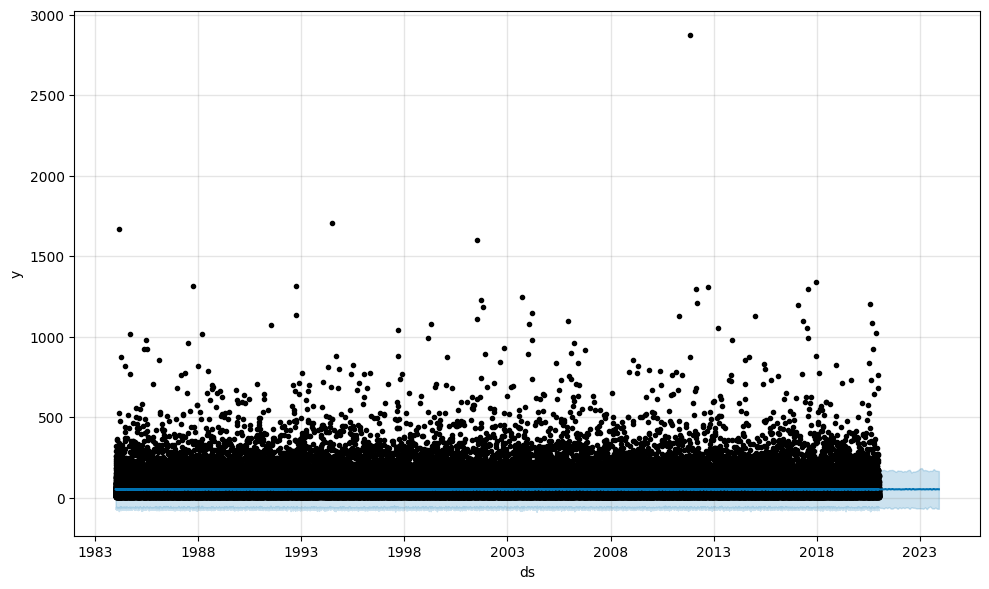

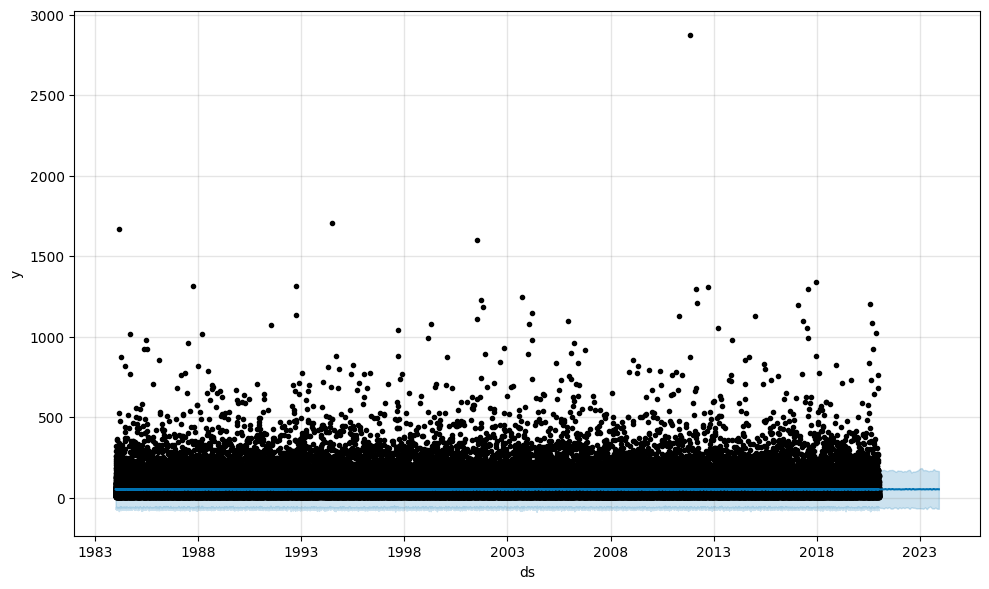

In [38]:
my_model.plot(forecast, uncertainty=True)

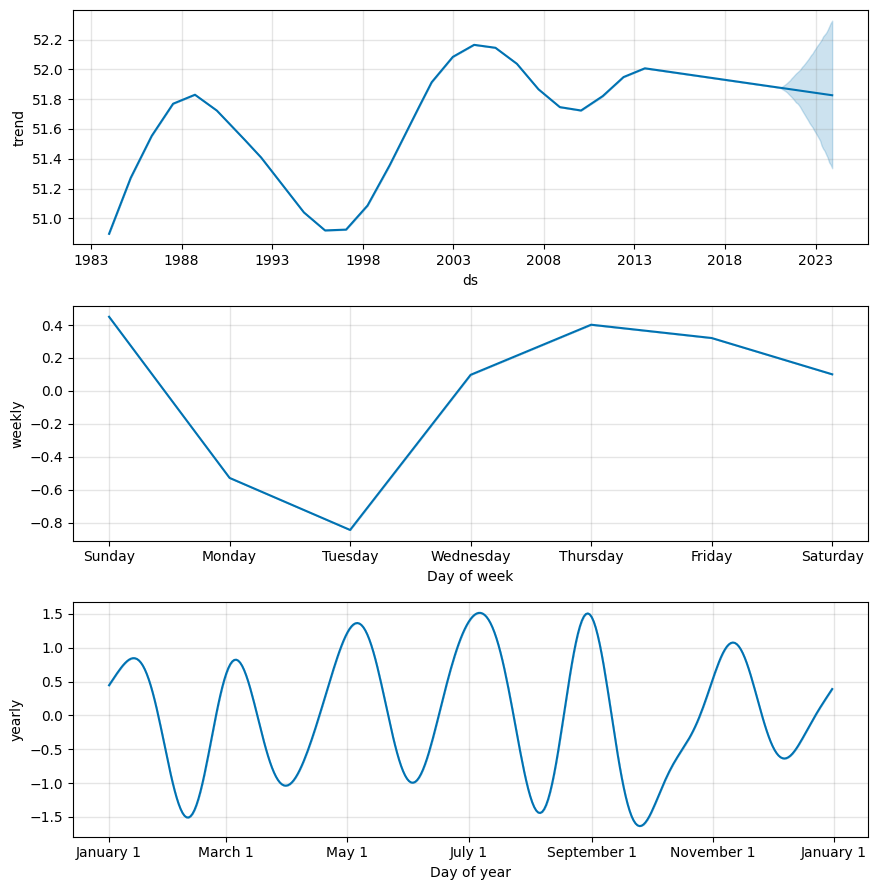

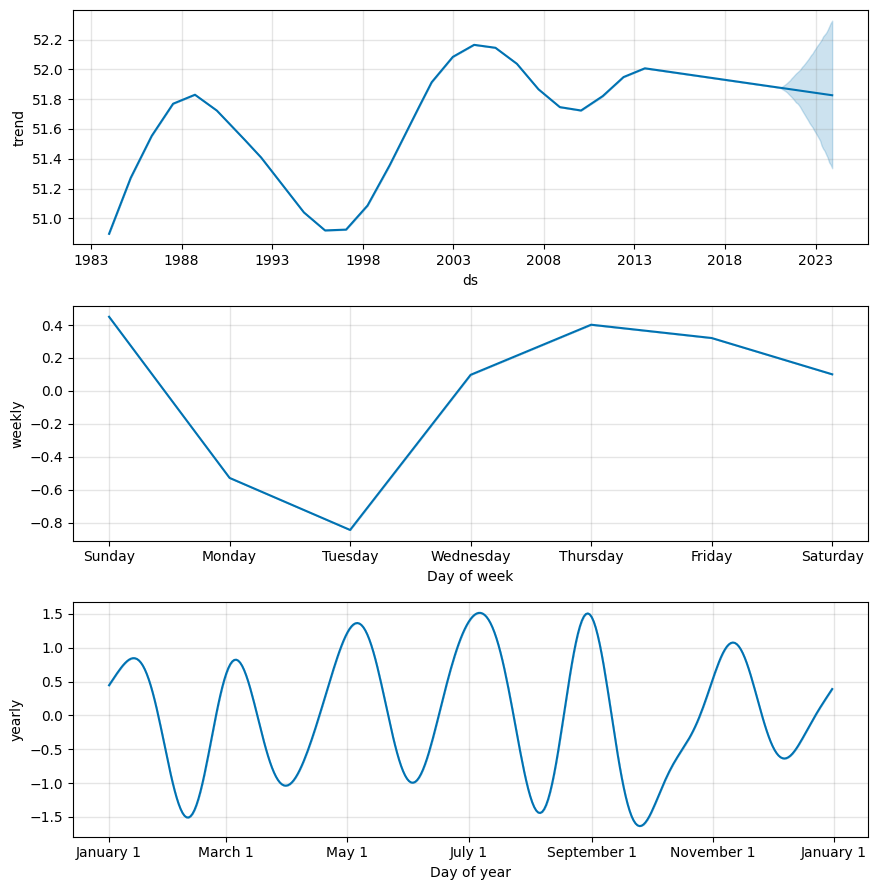

In [39]:
my_model.plot_components(forecast)

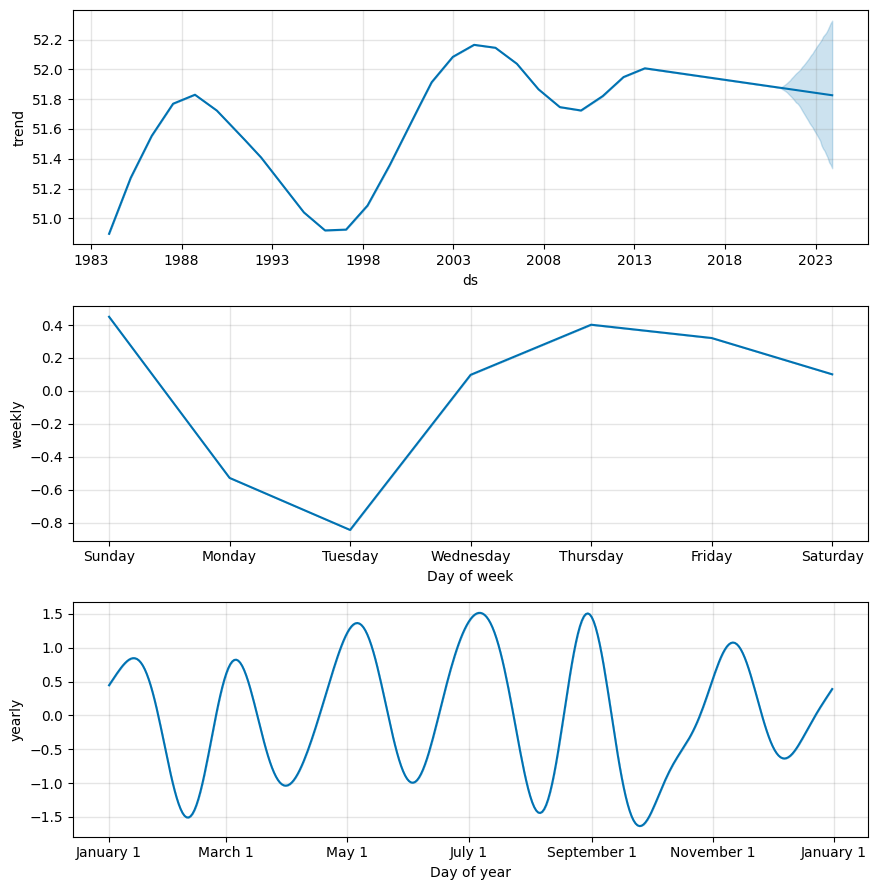

In [40]:
fig1 = my_model.plot_components(forecast)

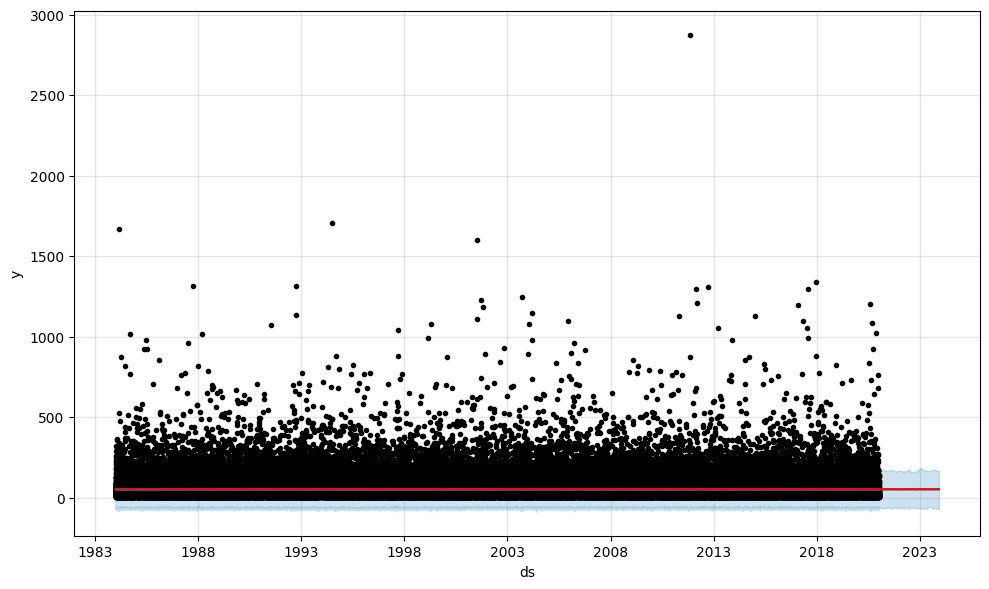

In [41]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

In [42]:
my_model.changepoints

4805     1985-03-03
9610     1986-05-01
14414    1987-07-12
19219    1988-09-26
24024    1989-12-06
28829    1991-02-27
33633    1992-05-11
38438    1993-07-16
43243    1994-09-26
48048    1995-12-01
52852    1997-01-29
57657    1998-04-04
62462    1999-06-08
67267    2000-08-08
72071    2001-10-16
76876    2002-12-18
81681    2004-02-22
86486    2005-04-27
91290    2006-07-01
96095    2007-09-06
100900   2008-11-15
105705   2010-01-18
110509   2011-03-23
115314   2012-05-20
120119   2013-07-26
Name: ds, dtype: datetime64[ns]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/sjvnkj58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/k_x1o391.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73374', 'data', 'file=/tmp/tmptqvufj43/sjvnkj58.json', 'init=/tmp/tmptqvufj43/k_x1o391.json', 'output', 'file=/tmp/tmptqvufj43/prophet_modelw3vzxmst/prophet_model-20231026065808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


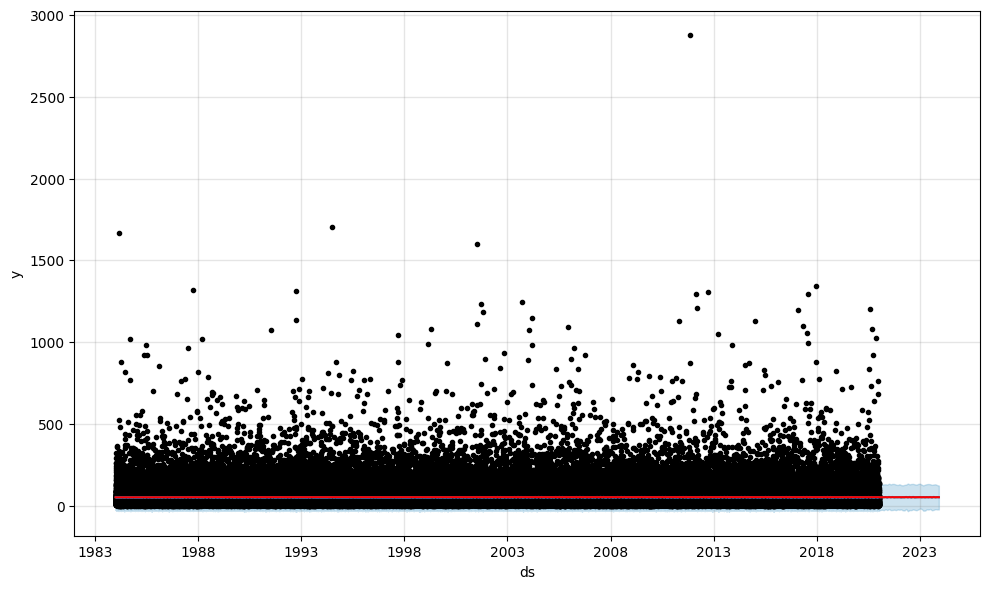

In [43]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/h_5kl0f8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/8fkj0u7v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16760', 'data', 'file=/tmp/tmptqvufj43/h_5kl0f8.json', 'init=/tmp/tmptqvufj43/8fkj0u7v.json', 'output', 'file=/tmp/tmptqvufj43/prophet_model5kp297h6/prophet_model-20231026065831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


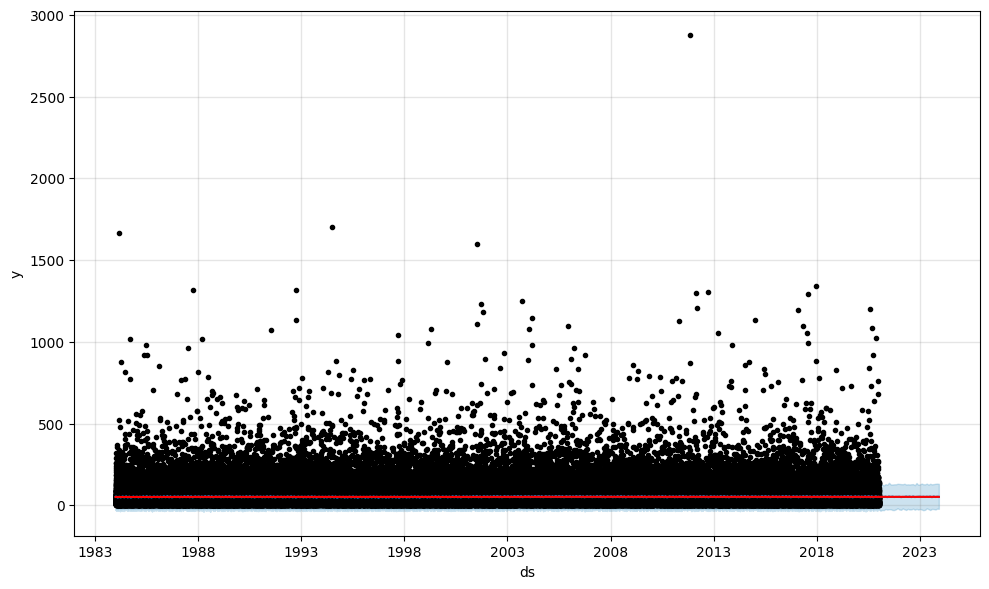

In [44]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/7mlmavlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/z2gn45u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36606', 'data', 'file=/tmp/tmptqvufj43/7mlmavlv.json', 'init=/tmp/tmptqvufj43/z2gn45u9.json', 'output', 'file=/tmp/tmptqvufj43/prophet_modelzmyoc_wv/prophet_model-20231026065855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


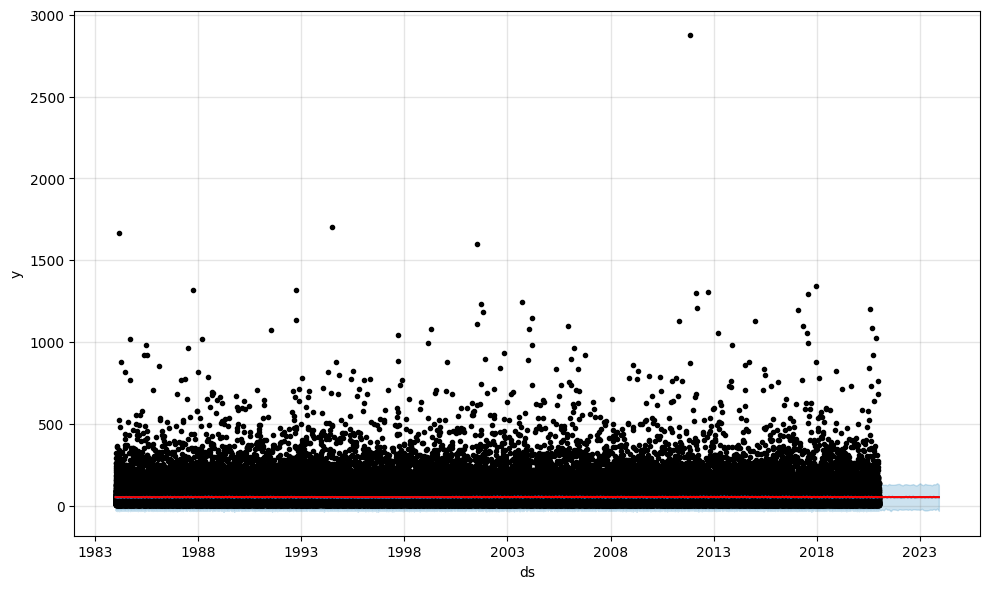

In [45]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/73sw7olv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptqvufj43/ubawn3ef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95175', 'data', 'file=/tmp/tmptqvufj43/73sw7olv.json', 'init=/tmp/tmptqvufj43/ubawn3ef.json', 'output', 'file=/tmp/tmptqvufj43/prophet_modeldoldhvgc/prophet_model-20231026065923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:59:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:59:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


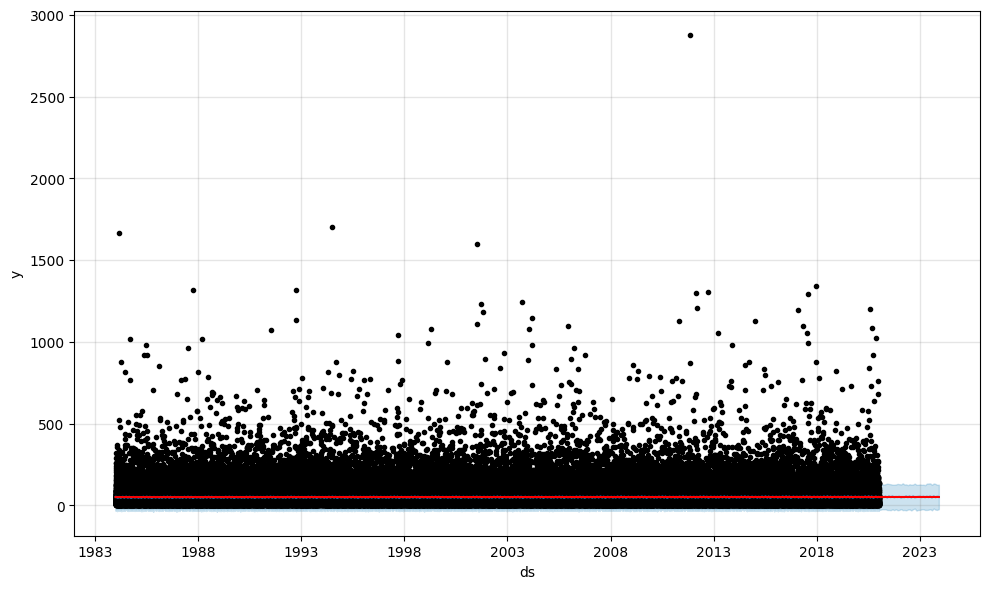

In [46]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)